In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(tf.__version__)

1.8.0


In [2]:
#Read The Data
imgdata=pd.read_csv('train.csv')
imgdata.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Split the Data
randmask=np.random.randn(len(imgdata))<0.8
testdata=imgdata[~randmask]
traindata=imgdata[randmask]

In [4]:
x_train=traindata.iloc[1:,1:]
y_train=traindata.iloc[1:,0]
x_test=testdata.iloc[1:,1:]
y_test=testdata.iloc[1:,0]

In [5]:
def label_to_one(y): #one Hot Encoding Function
    y_new=np.zeros([len(y),10])
    for i, val in enumerate(y):
        y_new[i,val]=1
    return y_new

In [6]:
y_train_one=label_to_one(y_train)
print(y_train_one[20])
print(y_train.iloc[20])

[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
3


In [7]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
            strides=[1, 2, 2, 1], padding='SAME')
def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)
def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b
    

In [8]:
X=tf.placeholder(tf.float32,shape=[None,784])
Y=tf.placeholder(tf.float32,shape=[None,10])

In [9]:
x_img=tf.reshape(X,[-1,28,28,1])

conv1=conv_layer(x_img,[5,5,1,32])
conv1_pool=max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*64])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)
y_conv = full_layer(full1_drop, 10)

In [10]:
with tf.name_scope('adam_optimizer'):
    alpha=1e-4
    los=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=y_conv))
    opt=tf.train.AdamOptimizer(alpha).minimize(los)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [11]:
def get_batch(x,y,bid,size=50):
    if (bid+1)*size > len(y):
        bid=0
    return x.iloc[bid*size:(bid+1)*size,:],y[bid*size:(bid+1)*size,:]
    
    

In [ ]:
sess=tf.Session()
steps=500
sess.run(tf.global_variables_initializer())
for i in range(steps):
        batchx,batchy = get_batch(x_train,y_train_one,i,size=100)
        if i % 100 == 0:
            train_accuracy = sess.run(accuracy, feed_dict={X: batchx,Y: batchy,keep_prob: 1.0})
            print( "step "+str(i)+" training accuracy "+str(train_accuracy))
        sess.run(opt, feed_dict={X: batchx, Y: batchy,keep_prob: 0.5})
    

step 0 training accuracy 0.12
step 100 training accuracy 0.85
step 200 training accuracy 0.97
step 300 training accuracy 0.98


In [20]:
## Test Set Accuracy
y_test_one=label_to_one(y_test)
test_accuracy=np.zeros(80)
for i in range(80):
    batchx,batchy = get_batch(x_test,y_test_one,i,size=100)
    test_accuracy[i] = sess.run(accuracy,feed_dict={X:batchx, Y:batchy,keep_prob:1.0})
print("Test Accuracy " + str(np.mean(test_accuracy)*100))

Test Accuracy 92.962500006


In [16]:
def predict(x,sess):
    y = sess.run(y_conv,feed_dict={X:x,keep_prob:1.0})
    return y

8


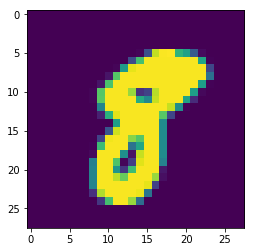

In [37]:
i=200

x=x_test.iloc[i]
x_arr=x.values
y=predict(x_arr.reshape(1,784),sess)
print(np.argmax(y))
plt.imshow(x_arr.reshape(28,28))

In [15]:
import matplotlib.image as mpimg


In [17]:

testimgs=['9','2','5','7','6'] ## Manual input 
for i in testimgs:
    xtest=mpimg.imread('testimgs/'+i+'.jpg')
    #plt.imshow(xtest/255)
    print('Actuall: '+i,end='')
    xtest=xtest[:,:,0]
    xtest=xtest.reshape(1,784)
    preds=predict(xtest,sess)
    print(' Predicted: ',end='')
    print(np.argmax(preds))
    #|print(preds)


Actuall: 9 Predicted: 2
Actuall: 2 Predicted: 2
Actuall: 5 Predicted: 2
Actuall: 7 Predicted: 7
Actuall: 6 Predicted: 8
